# Training Efficiency Analysis

This notebook analyzes training efficiency by plotting success rate vs total steps:
- Downloads training history from either training runs (Episode/success_rate) or eval runs
- Plots mean success rate with 95% CI shaded region
- Shows threshold line at 90% and labels steps to reach it

Set `DATA_SOURCE = "training"` or `DATA_SOURCE = "eval"` in Block 1 to choose data source.

In [1]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Method Tags
METHOD_TAGS = {
    "Pose": "pose_perf-comp:2026-01-05_10:54",
    "Hybrid-Basic": "basic-hybrid_perf-comp:2026-01-05_10:54",
    "SWISH": "LCLoP_fix_perf-comp:2026-01-09_11:17",
}

# Data Source Configuration
# Set to "training" to use Episode/success_rate from training runs
# Set to "eval" to use Eval_Core metrics from eval_performance runs
DATA_SOURCE = "training"

# Evaluation Tags (used when DATA_SOURCE = "eval")
TAG_EVAL_PERFORMANCE = "eval_performance"

# Metrics
METRIC_SUCCESS_TRAINING = "Episode/success_rate"  # For training runs
METRIC_SUCCESS_EVAL = "num_successful_completions"  # For eval runs
METRIC_TOTAL_EVAL = "total_episodes"  # For eval runs


In [2]:
# ============================================================
# BLOCK 2: DOWNLOAD TRAINING DATA
# ============================================================

def download_training_history_from_training_runs(api, method_tag):
    """Download Episode/success_rate history from training runs (not eval runs)."""
    # Get training runs (exclude eval_performance tag)
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": {"$ne": TAG_EVAL_PERFORMANCE}}]}
    )
    
    all_data = []
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Extract relevant columns
        for _, row in history.iterrows():
            if pd.notna(row.get("total_steps")) and pd.notna(row.get(METRIC_SUCCESS_TRAINING)):
                # Episode/success_rate is already a percentage (0-100)
                success_rate = row[METRIC_SUCCESS_TRAINING] * 100  # Convert from 0-1 to 0-100 if needed
                all_data.append({
                    "run_id": run.id,
                    "run_name": run.name,
                    "total_steps": int(row["total_steps"]),
                    "success_rate": success_rate,
                })
        
        print(f"  {run.name}: {len(history)} checkpoints")
    
    return pd.DataFrame(all_data)

def download_training_history_from_eval_runs(api, method_tag):
    """Download success rate history from eval_performance runs."""
    runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    all_data = []
    for run in runs:
        history = run.history()
        if history.empty:
            print(f"Warning: Run {run.name} has no history data")
            continue
        
        # Extract relevant columns
        for _, row in history.iterrows():
            if pd.notna(row.get("total_steps")) and pd.notna(row.get(f"Eval_Core/{METRIC_SUCCESS_EVAL}")):
                success_rate = 100 * row[f"Eval_Core/{METRIC_SUCCESS_EVAL}"] / row[f"Eval_Core/{METRIC_TOTAL_EVAL}"]
                all_data.append({
                    "run_id": run.id,
                    "run_name": run.name,
                    "total_steps": int(row["total_steps"]),
                    "success_rate": success_rate,
                })
        
        print(f"  {run.name}: {len(history)} checkpoints")
    
    return pd.DataFrame(all_data)

# Download training data for each method
api = wandb.Api()
training_data = {}

print(f"Data Source: {DATA_SOURCE}")
print("=" * 60)

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    if DATA_SOURCE == "training":
        training_data[method_name] = download_training_history_from_training_runs(api, method_tag)
    else:
        training_data[method_name] = download_training_history_from_eval_runs(api, method_tag)

# Print summary
print("\n" + "=" * 60)
print("DATA SUMMARY")
print("=" * 60)
for method_name, df in training_data.items():
    if not df.empty:
        n_runs = df["run_name"].nunique()
        n_steps = df["total_steps"].nunique()
        print(f"{method_name}: {n_runs} runs, {n_steps} unique steps")
    else:
        print(f"{method_name}: No data")

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Data Source: training

Pose (pose_perf-comp:2026-01-05_10:54):
  pose_perf-comp_f(10)_0: 78 checkpoints
  pose_perf-comp_f(10)_1: 78 checkpoints
  pose_perf-comp_f(10)_3: 78 checkpoints
  pose_perf-comp_f(10)_2: 78 checkpoints
  pose_perf-comp_f(10)_4: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_0: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_1: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_3: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_2: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_4: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_0: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_1: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_3: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_2: 78 checkpoints
  Eval_noise_pose_perf-comp_f(10)_4: 78 checkpoints

Hybrid-Basic (basic-hybrid_perf-comp:2026-01-05_10:54):
  basic-hybrid_perf-comp_f(10)_0: 78 checkpoints
  basic-hybrid_perf-comp_f(10)_1: 78 checkpoints
  basic-hybrid_perf-comp_f(10)_2: 78 checkpoints
  basic-

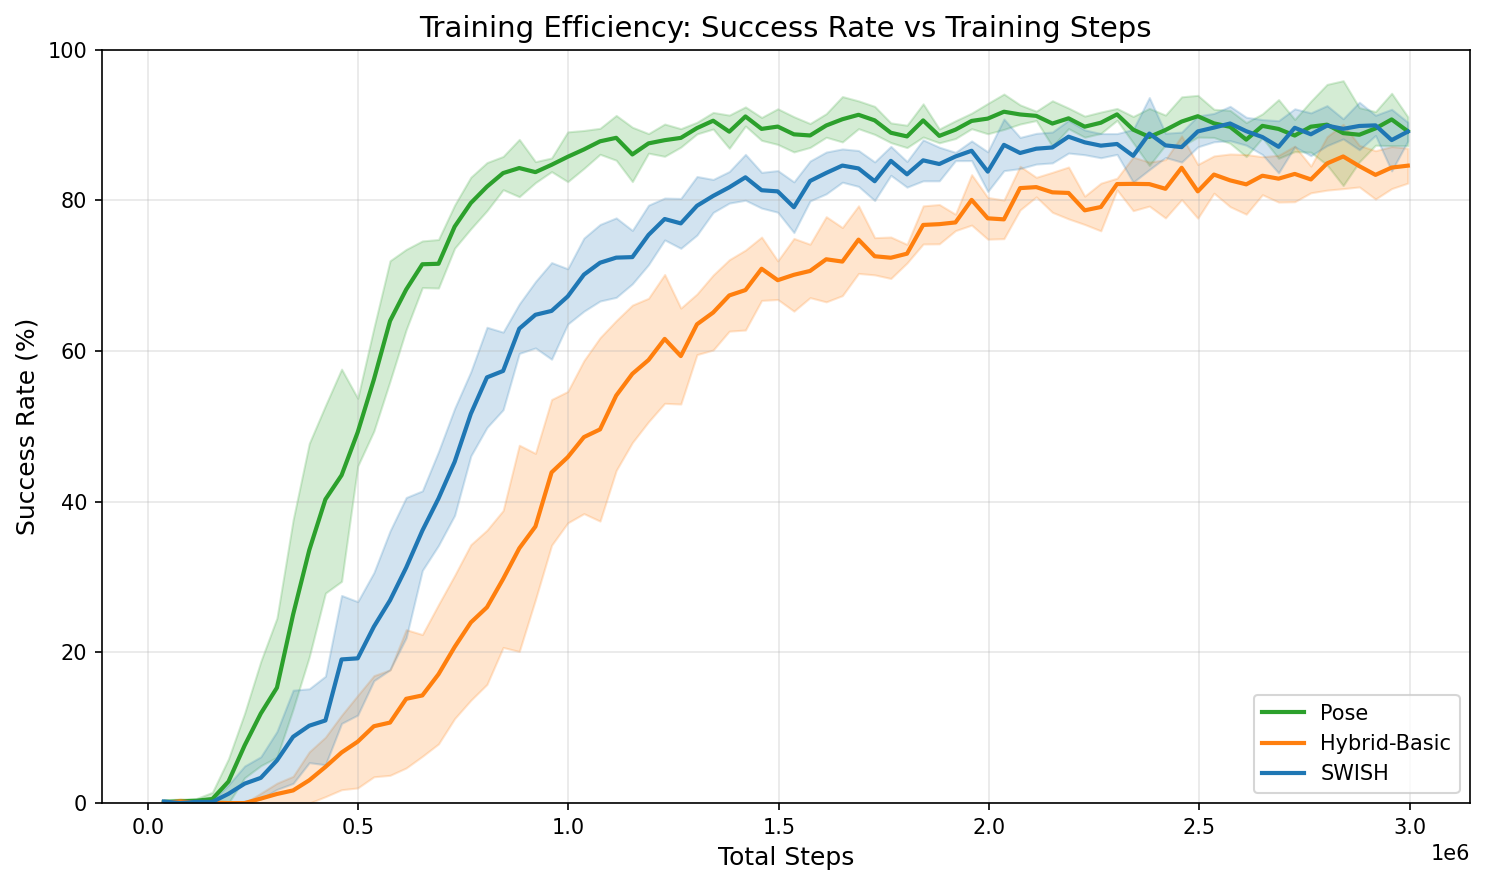

In [4]:
# ============================================================
# BLOCK 3: TRAINING EFFICIENCY PLOT
# ============================================================

# Figure Configuration
FIGSIZE = (10, 6)
DPI = 150

# Colors
COLORS = {
    "Pose": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "SWISH": "#1f77b4",       # Blue
}

# Threshold Configuration
SUCCESS_THRESHOLD = 80  # Percentage threshold for labeling
# Shading alpha for confidence interval
CI_ALPHA = 0.2

# Font sizes
FONT_TITLE = 14
FONT_AXIS_LABEL = 12
FONT_TICK = 10
FONT_LEGEND = 10
FONT_ANNOTATION = 9

# Axis configuration
Y_LIM = (0, 100)
Y_TICKS = [0, 20, 40, 60, 80, 100]

# Labels
TITLE = "Training Efficiency: Success Rate vs Training Steps"
X_LABEL = "Total Steps"
Y_LABEL = "Success Rate (%)"

# Threshold line configuration
THRESHOLD_COLOR = "black"
THRESHOLD_LINESTYLE = "--"
THRESHOLD_LINEWIDTH = 1.5

# Annotation toggle
SHOW_ANNOTATIONS = False  # Set to False to hide threshold line and step annotations

# Annotation configuration
ANNOTATION_COLOR = "black"
ANNOTATION_Y_POS = 5  # Y position above x-axis for text
ANNOTATION_Y_OFFSET = 6  # Offset for stacking annotations vertically

# ============================================================

def compute_stats_by_step(df):
    """Compute mean and 95% CI for each unique step across all runs."""
    if df.empty:
        return pd.DataFrame()
    
    # Group by total_steps and compute statistics
    stats = df.groupby("total_steps")["success_rate"].agg(["mean", "std", "count"]).reset_index()
    stats.columns = ["total_steps", "mean", "std", "count"]
    
    # Calculate SEM and 95% CI
    stats["sem"] = stats["std"] / np.sqrt(stats["count"])
    stats["ci_95"] = 1.96 * stats["sem"]
    
    # Calculate upper and lower bounds (clipped to [0, 100])
    stats["lower"] = (stats["mean"] - stats["ci_95"]).clip(0, 100)
    stats["upper"] = (stats["mean"] + stats["ci_95"]).clip(0, 100)
    
    # Sort by steps
    stats = stats.sort_values("total_steps")
    
    return stats

def find_threshold_crossing(stats, threshold):
    """Find the first step where mean success rate >= threshold."""
    if stats.empty:
        return None
    
    crossing = stats[stats["mean"] >= threshold]
    if crossing.empty:
        return None
    
    return crossing.iloc[0]["total_steps"]

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Store threshold crossings for annotations
threshold_crossings = {}

# Plot each method
for method_name in METHOD_TAGS.keys():
    df = training_data[method_name]
    stats = compute_stats_by_step(df)
    
    if stats.empty:
        print(f"Warning: No data for {method_name}")
        continue
    
    color = COLORS[method_name]
    
    # Plot mean line
    ax.plot(stats["total_steps"], stats["mean"], 
            color=color, label=method_name, linewidth=2)
    
    # Plot 95% CI shaded region
    ax.fill_between(stats["total_steps"], stats["lower"], stats["upper"],
                    color=color, alpha=CI_ALPHA)
    
    # Find threshold crossing
    crossing_step = find_threshold_crossing(stats, SUCCESS_THRESHOLD)
    if crossing_step is not None:
        threshold_crossings[method_name] = crossing_step

# Plot threshold line (conditional on SHOW_ANNOTATIONS)
if SHOW_ANNOTATIONS:
    ax.axhline(y=SUCCESS_THRESHOLD, color=THRESHOLD_COLOR, 
               linestyle=THRESHOLD_LINESTYLE, linewidth=THRESHOLD_LINEWIDTH,
               label=f"{SUCCESS_THRESHOLD}% Threshold")

# Add threshold crossing annotations (conditional on SHOW_ANNOTATIONS)
if SHOW_ANNOTATIONS:
    print("\n" + "=" * 60)
    print(f"STEPS TO REACH {SUCCESS_THRESHOLD}% SUCCESS RATE")
    print("=" * 60)

    for i, (method_name, crossing_step) in enumerate(sorted(threshold_crossings.items(), key=lambda x: x[1])):
        # Print to console
        print(f"{method_name}: {crossing_step:,} steps")
        
        # Add vertical line at crossing point
        ax.axvline(x=crossing_step, color=ANNOTATION_COLOR, linestyle=":", alpha=0.5, linewidth=1)
        
        # Add text annotation above x-axis, next to vertical line (horizontal text)
        y_pos = ANNOTATION_Y_POS + (i * ANNOTATION_Y_OFFSET)
        ax.text(crossing_step, y_pos, f"{method_name}: {crossing_step:,}", 
                fontsize=FONT_ANNOTATION, color=ANNOTATION_COLOR,
                ha='left', va='bottom')

# Configure axes
ax.set_xlabel(X_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_ylabel(Y_LABEL, fontsize=FONT_AXIS_LABEL)
ax.set_title(TITLE, fontsize=FONT_TITLE)
ax.set_ylim(Y_LIM)
ax.set_yticks(Y_TICKS)
ax.tick_params(axis='both', labelsize=FONT_TICK)

# Format x-axis with scientific notation or commas
ax.ticklabel_format(axis='x', style='scientific', scilimits=(6, 6))

# Legend in bottom right
ax.legend(fontsize=FONT_LEGEND, loc='lower right')

# Grid for readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()